In [1]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 30.10 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls track

driving_log.csv  IMG


In [3]:
!pip install imgaug

In [4]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import ntpath

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

%matplotlib inline

In [5]:
datadir = "track"

#         ["merkez","sol","sağ","direksiyon","gaz kelebeği","geri","hız"]
columns = ["center","left","right","steering","throttle","reverse","speed"]

df = pd.read_csv(os.path.join(datadir,"driving_log.csv"))
df.columns = columns

pd.set_option("display.max_colwidth",-1)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_930.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_930.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_930.jpg,0.0,0.0,0.0,0.610506


In [6]:
def path_leaf(path):

    head, tail = ntpath.split(path)
    return tail
    
df["center"] = df["center"].apply(path_leaf)
df["left"] = df["left"].apply(path_leaf)
df["right"] = df["right"].apply(path_leaf)

In [7]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
1,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
2,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
3,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438
4,center_2018_07_16_17_11_43_930.jpg,left_2018_07_16_17_11_43_930.jpg,right_2018_07_16_17_11_43_930.jpg,0.0,0.0,0.0,0.610506


In [8]:
len(df),df["steering"].nunique(),df["steering"].max(),df["steering"].min()

(4052, 580, 1.0, -1.0)

In [9]:
num_bins = 25

hist, bins = np.histogram(df["steering"],num_bins)

print("Hist : ", hist)
print("Lenght Hist : ", len(hist))
print()
print("Bins : ",bins )
print("Lenght Bins : ", len(bins))

Hist :  [  35    6    6    6   13    8   24   22   53  131   99  158 2989  137
   86  126   54   22   19    2    9    4    4    6   33]
Lenght Hist :  25

Bins :  [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
Lenght Bins :  26


In [10]:
bins[1:],bins[:-1]

(array([-0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36, -0.28,
        -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,  0.44,
         0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92]))

In [11]:
center = (bins[1:] + bins[:-1]) * 0.5
len(center),len(hist),len(bins)

(25, 25, 26)

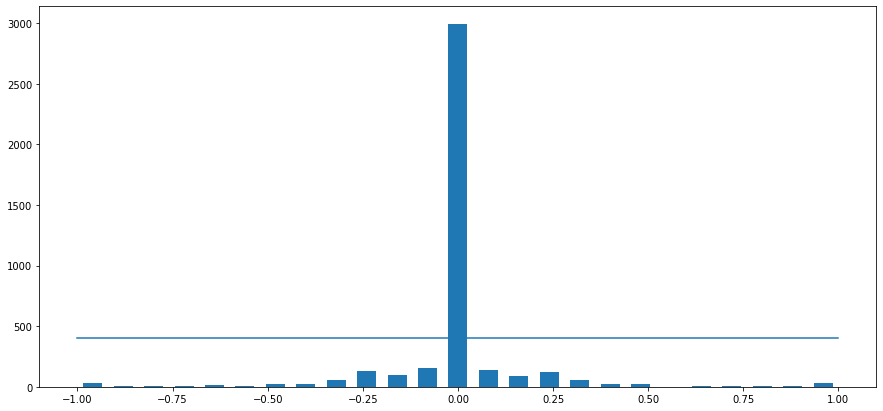

In [12]:
samples_per_bin = 400

plt.figure(figsize = (15,7))
plt.bar(center,hist,width = 0.05)
plt.plot( (np.min(df["steering"]), np.max(df["steering"])), (samples_per_bin,samples_per_bin) )
plt.show()

In [13]:
len(bins),len(df["steering"]),bins

(26,
 4052,
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]))

In [14]:
print("Total Data : ", len(df))

remove_list = []

samples_per_bin = 400
num_bins = 25

for j in range(num_bins):

    list_=[]
    for i in range(len(df["steering"])):

        # Bins arasındaki değeri istiyoruz yani -1 ile -0.92 arasında ve kendileride dahil !!!
        if df["steering"][i] >= bins[j] and df["steering"][i] <= bins[j+1]:
            list_.append(i) # İndex kısmını yakaladık burada !! 

    #print()
    list_ = shuffle(list_)
    #print("Shuffle : ", len(list_))
    list_ = list_[samples_per_bin:]
    #print("400 > :", len(list_))
    remove_list.extend(list_)
    #print()

print("Removed : ", len(remove_list))
df.drop(df.index[remove_list], inplace = True)
print("Remaning : ", len(df))

Total Data :  4052
Removed :  2589
Remaning :  1463


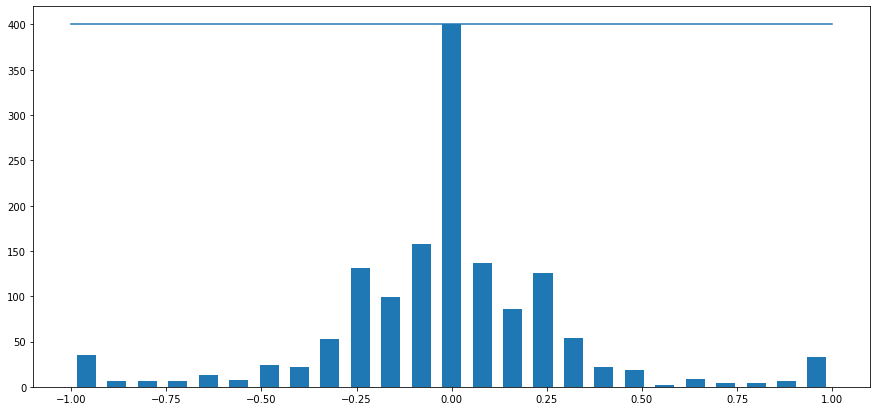

In [15]:
# Bunu yapmamızdaki amaç şu normalde 0 değeri çok fazla olması bizim eğitim verimiz için çok artı bir durum değil
# Aracın sağa sola gitmesi önemli 
# 0 değerinin çok olması yani düz gitme ihtimali her zaman daha çok fazla olması 
# Eğitimde bize sıkıntı oluşturur

hist, _ = np.histogram(df["steering"], num_bins)

plt.figure(figsize = (15,7))
plt.bar(center, hist, width = 0.05)
plt.plot( (np.min(df["steering"]), np.max(df["steering"])), (samples_per_bin,samples_per_bin))
plt.show()

In [16]:
df.iloc[0]

center      center_2018_07_16_17_11_43_998.jpg
left        left_2018_07_16_17_11_43_998.jpg  
right       right_2018_07_16_17_11_43_998.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.606834                          
Name: 5, dtype: object

In [17]:
def load_img_steering(datadir,data):

    image_path = []
    steering = []
    for i in range(len(data)):

        indexed_data = data.iloc[i]
        center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]

        # Center Image Append
        image_path.append(os.path.join(datadir,center.strip()))
        steering.append(float(indexed_data[3]))

        # Left Image Append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)

        # Right Image Append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)

    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)

    return image_paths,steerings

In [18]:
image_paths, steerings = load_img_steering(datadir + "/IMG", df)

In [19]:
X_train , X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3511,), (878,), (3511,), (878,))

In [20]:
3511 / 3

1170.3333333333333

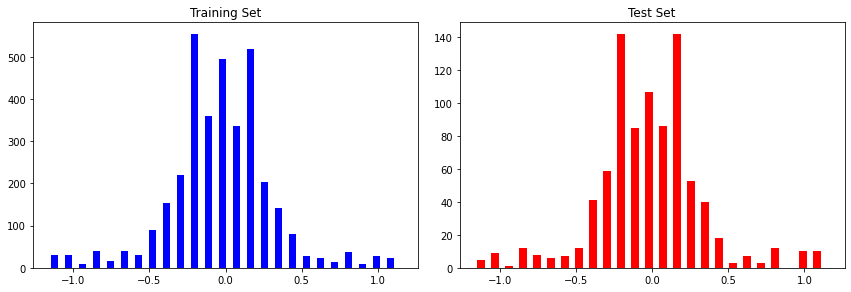

In [21]:
fig,axes = plt.subplots(1,2,figsize = (12,4))
fig.tight_layout()

axes[0].hist(y_train,bins = num_bins, width = 0.05, color = "blue")
axes[0].set_title("Training Set")

axes[1].hist(y_test,bins = num_bins, width = 0.05, color = "red")
axes[1].set_title("Test Set")

plt.show()

In [22]:
def zoom(image):
    zoom = iaa.Affine(scale = (1 , 1.3))
    image = zoom.augment_image(image)

    return image

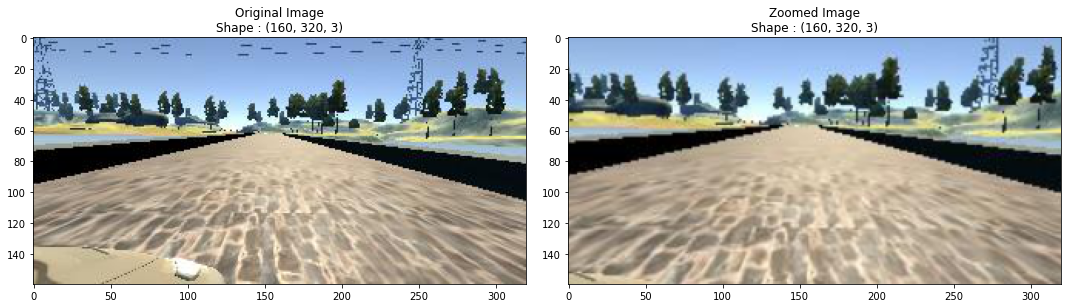

In [23]:
image = image_paths[np.random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig , axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nShape : {original_image.shape}")

axes[1].imshow(zoomed_image)
axes[1].set_title(f"Zoomed Image\nShape : {original_image.shape}")

plt.show()

In [24]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x" : (-0.1,0.1), "y" : (-0.1,0.1) })
    image = pan.augment_image(image)
    return image

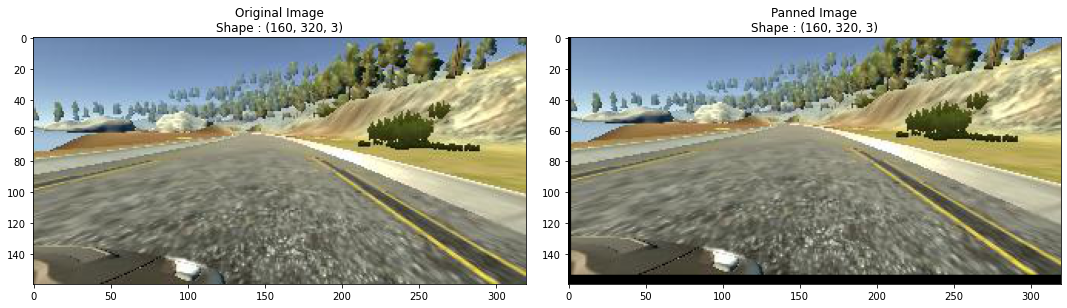

In [25]:
image = image_paths[np.random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig , axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nShape : {original_image.shape}")

axes[1].imshow(panned_image)
axes[1].set_title(f"Panned Image\nShape : {panned_image.shape}")

plt.show()

In [26]:
def img_random_brightness(image):

    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

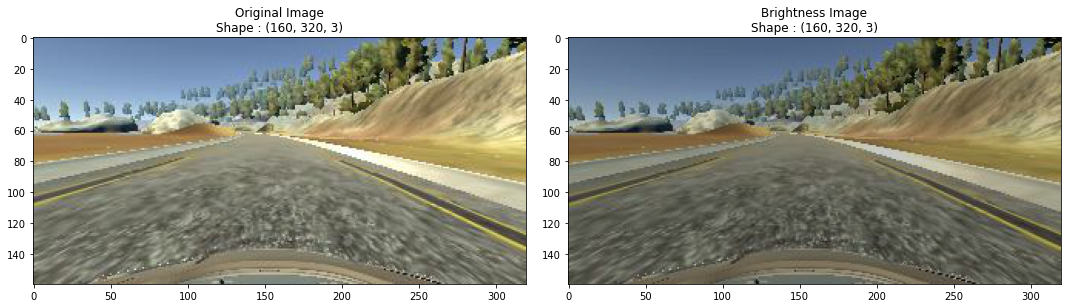

In [27]:
image = image_paths[np.random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_image = img_random_brightness(original_image)

fig , axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nShape : {original_image.shape}")

axes[1].imshow(brightness_image)
axes[1].set_title(f"Brightness Image\nShape : {brightness_image.shape}")

plt.show()

In [28]:
def img_random_flip(image,steering_angle):

    # 1 Horizantal
    # 0 Vertical
    # -1 both of them !!!

    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image , steering_angle

In [29]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

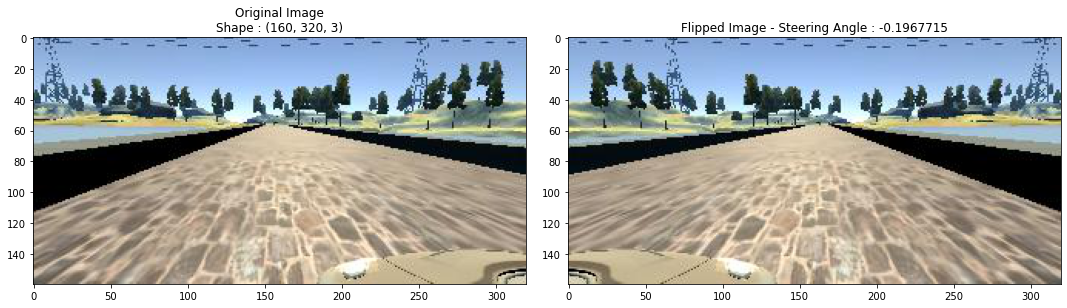

In [30]:
random_index = np.random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig , axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nShape : {original_image.shape}")

axes[1].imshow(flipped_image)
axes[1].set_title("Flipped Image - " + "Steering Angle : " + str(flipped_steering_angle))

plt.show()

In [31]:
np.random.rand() < 0.5, np.random.rand()

(False, 0.8078662395204477)

In [32]:
def random_augment(image, steering_angle):

    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image= pan(image)
    if np.random.rand() < 0.5:
        image= zoom(image)
    if np.random.rand() < 0.5:
        image= img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle= img_random_flip(image,steering_angle)

    return image, steering_angle

In [33]:
ncol = 2
nrow = 10

fig ,axes = plt.subplots(nrow, ncol, figsize = (15,50))
fig.tight_layout()

for i in range(10):

    random = np.random.randint(0, len(image_paths)-1)
    random_image = image_paths[random]
    random_steering = steerings[random]

    original_image = mpimg.imread(random_image)
    augmented_image, steering_angle = random_augment(random_image, random_steering)

    axes[i][0].imshow(original_image)
    axes[i][0].set_title("Original Image")

    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title("Augmented Image")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [34]:
def img_preprocess(image):

    #img = mpimg.imread(image)
    img = image[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, ksize = (3,3), sigmaX = 0)
    img = cv2.resize(img, (200,66))
    img = img / 255
    return img

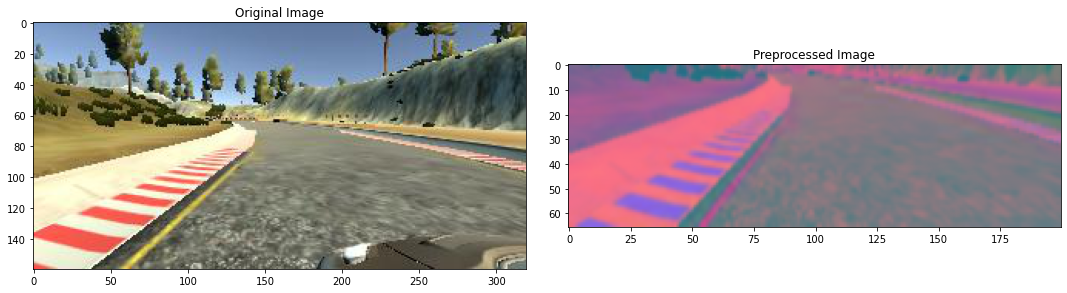

In [35]:
index = image_paths[100]

original_image = mpimg.imread(index)

preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1,2,figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title("Original Image")

axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")

plt.show()

In [36]:
#X_train = np.array(list(map(img_preprocess,X_train)))
#X_test = np.array(list(map(img_preprocess,X_test)))

In [37]:
#i = np.random.randint(0, len(X_train) - 1)

#plt.imshow(X_train[i])
#plt.title(f"Shape : {X_train[i].shape}")
#plt.show()

In [38]:
def batch_generator(image_paths,steering_ang,batch_size , istraining):

    while True:

        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = np.random.randint(0,len(image_paths)-1)

            if istraining:
                img, steering = random_augment(image_paths[random_index],steering_ang[random_index])
            
            else:
                img = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            img = img_preprocess(img)
            batch_img.append(img)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [39]:
X_train_gen,y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_test_gen,y_test_gen = next(batch_generator(X_test,y_test,1,0))

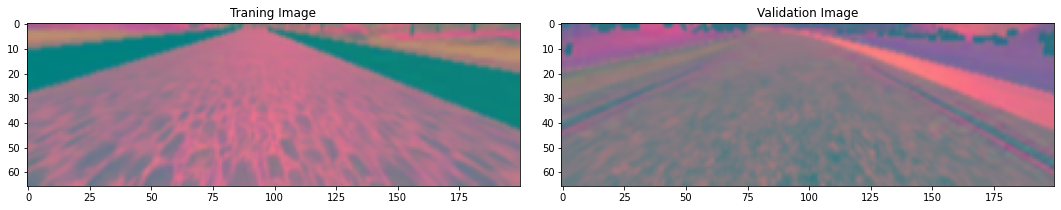

In [40]:
fig ,axes = plt.subplots(1,2,figsize = (15,10))
fig.tight_layout()

i=0

axes[0].imshow(X_train_gen[i])
axes[0].set_title("Traning Image")


axes[1].imshow(X_test_gen[i])
axes[1].set_title("Validation Image")

plt.show()

In [41]:
X_train_gen.shape

(1, 66, 200, 3)

In [42]:
def nvidia_model():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Convolution2D(filters = 24,  kernel_size = (5,5), strides = (2,2), activation = "elu", input_shape = (66,200,3)))
    model.add(tf.keras.layers.Convolution2D(filters = 36,  kernel_size = (5,5), strides = (2,2), activation = "elu"))
    model.add(tf.keras.layers.Convolution2D(filters = 48,  kernel_size = (5,5), strides = (2,2), activation = "elu"))
    model.add(tf.keras.layers.Convolution2D(filters = 64,  kernel_size = (3,3), activation = "elu"))
    
    model.add(tf.keras.layers.Convolution2D(filters = 64,  kernel_size = (3,3),  activation = "elu"))
    #model.add(tf.keras.layers.Dropout(rate = 0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units = 100, activation = "elu"))
    #model.add(tf.keras.layers.Dropout(rate = 0.5))

    model.add(tf.keras.layers.Dense(units = 50, activation = "elu"))
    #model.add(tf.keras.layers.Dropout(rate = 0.5))

    model.add(tf.keras.layers.Dense(units = 10, activation = "elu"))
    #model.add(tf.keras.layers.Dropout(rate = 0.5))

    model.add(tf.keras.layers.Dense(units = 1))
    
    # Dikkat et burası loss olarak "mse" olarak tanımladık !!!
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = "mse")

    return model

In [43]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [44]:
h = model.fit_generator(batch_generator(X_train,y_train, batch_size = 100, istraining = 1),
                        steps_per_epoch = 300,
                        epochs = 10,
                        validation_data = batch_generator(X_test,y_test,batch_size = 100, istraining = 0),
                        validation_steps = 200,
                        verbose = 1,
                        shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
300/300 [==============================] - 232s 734ms/step - loss: 0.0884 - val_loss: 0.0666
Epoch 2/10
300/300 [==============================] - 223s 746ms/step - loss: 0.0670 - val_loss: 0.0493
Epoch 3/10
300/300 [==============================] - 223s 746ms/step - loss: 0.0599 - val_loss: 0.0479
Epoch 4/10
300/300 [==============================] - 218s 727ms/step - loss: 0.0554 - val_loss: 0.0447
Epoch 5/10
300/300 [==============================] - 220s 736ms/step - loss: 0.0531 - val_loss: 0.0371
Epoch 6/10
300/300 [==============================] - 217s 726ms/step - loss: 0.0498 - val_loss: 0.0341
Epoch 7/10
300/300 [==============================] - 220s 734ms/step - loss: 0.0476 - val_loss: 0.0329
Epoch 8/10
300/300 [==============================] - 218s 729ms/step - loss: 0.0442 - val_loss: 0.0311
Epoch 9/10
300/300 [==============================] - 219s 731ms/step - loss: 0.0433 - val_loss: 0.0310
Epoch 10/10
300/300 [==============================] - 217s 725m

In [45]:
def history_graph(history, epochs ):

    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(history.history["loss"],label = "Train")
    plt.plot(history.history["val_loss"], label = "Test")
    plt.title("Loss Score")
    plt.legend(loc = "best")
    plt.xticks(range(0,epochs + 1))

    plt.tight_layout()
    plt.show()

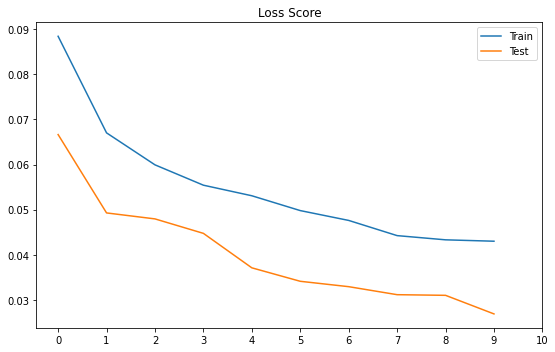

In [46]:
history_graph(h,10)

In [47]:
model.save("last_model.h5")

In [48]:
from google.colab import files

In [49]:
files.download("last_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>